In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# from scipy.stats import percentileofscore
from prettytable import PrettyTable
from collections import Counter

In [256]:
#save output
import sys
import logging

so = open("data.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [257]:
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memmory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)   
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem)/start_mem))
        
        return df

### breau.csv
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have loan in our sample)
- For every loan in our sample, there are as many rows as number of credits the clients had in Credit Bureau before the application data

Application data from previous loans that client got from other institutions and that were reported to Credit Bureau. 
One row per client's loan in Credit Bureau

### bureau_balance.csv
- Monthly blances of previous credits in Credit Bureau
- This table has one row for each month of history of every previous credit reported to Credit Bureau i.e the table has (#loans in sample # of relative previous credits # months where we have some history observable for the previous credits) rows 

# A - EDA

## 1. Bureau

In [258]:
bureau_data = reduce_memory_usage(pd.read_csv('bureau.csv'))
bureau_balance = reduce_memory_usage(pd.read_csv('bureau_balance.csv'))

Memmory usage of dataframe is 222.62 MB
Memory usage after optimization is 216.07 MB
Decreased by 2.9%
Memmory usage of dataframe is 624.85 MB
Memory usage after optimization is 520.70 MB
Decreased by 16.7%


In [259]:
bureau_data.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [260]:
bureau_data.shape

(1716428, 17)

In [261]:
bureau_data.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

#### Variables meaning:
- SK_ID_CURR:	ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau 	hashed
- SK_BUREAU_ID:	Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)	hashed
- CREDIT_ACTIVE:	Status of the Credit Bureau (CB) reported credits	
- CREDIT_CURRENCY:	Recoded currency of the Credit Bureau credit	recoded
- DAYS_CREDIT:	How many days before current application did client apply for Credit Bureau credit	time only relative to the application
- CREDIT_DAY_OVERDUE:	Number of days past due on CB credit at the time of application for related loan in our sample	
- DAYS_CREDIT_ENDDATE:	Remaining duration of CB credit (in days) at the time of application in Home Credit	time only relative to the application
- DAYS_ENDDATE_FACT:	Days since CB credit ended at the time of application in Home Credit (only for closed credit)	time only relative to the application
- AMT_CREDIT_MAX_OVERDUE:	Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)	
- CNT_CREDIT_PROLONG:	How many times was the Credit Bureau credit prolonged	
- AMT_CREDIT_SUM:	Current credit amount for the Credit Bureau credit	
- AMT_CREDIT_SUM_DEBT:	Current debt on Credit Bureau credit	
- AMT_CREDIT_SUM_LIMIT:	Current credit limit of credit card reported in Credit Bureau	
- AMT_CREDIT_SUM_OVERDUE:	Current amount overdue on Credit Bureau credit	
- CREDIT_TYPE:	Type of Credit Bureau credit (Car, cash,...)	
- DAYS_CREDIT_UPDATE:	How many days before loan application did last information about the Credit Bureau credit come	time only relative to the application
- AMT_ANNUITY:	Annuity of the Credit Bureau credit

In [262]:
bureau_data.duplicated().sum()

0

In [263]:
bureau_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08


/var/folders/b0/n1lz5zk51z374mpb3hyxn5n00000gp/T/ipykernel_6105/4050242966.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(numeric_df_corr, dtype = np.bool)


<AxesSubplot:>

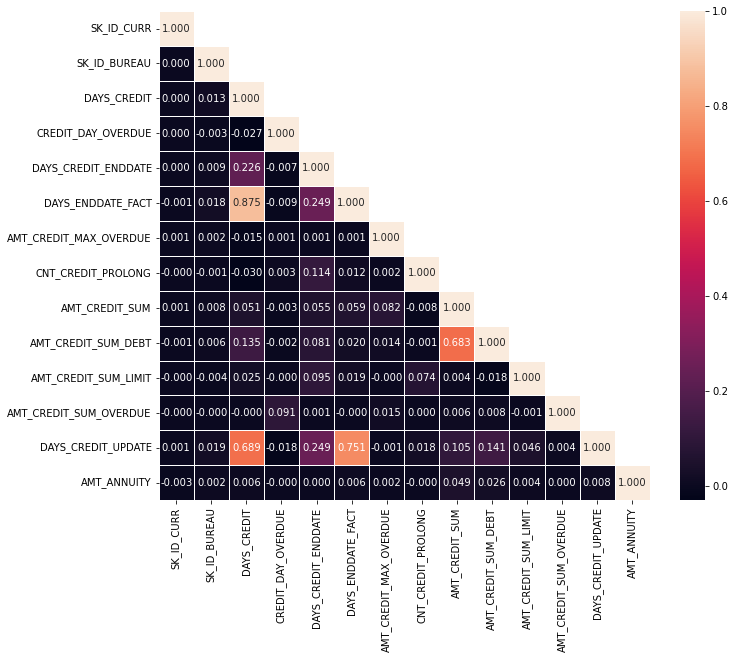

In [264]:
numeric_df = bureau_data._get_numeric_data()
numeric_df.shape[1] # 14 < 17
numeric_df_corr = numeric_df.corr()
numeric_df_corr

plt.figure(figsize = (11,9))
# generate a mask for upper triangle
mask = np.zeros_like(numeric_df_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(numeric_df_corr, mask = mask, annot = True, fmt = '.3f', linewidth = 0.5)

In [265]:
numeric_df_corr

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,1.000000,0.000135,0.000266,0.000283,0.000456,-0.000648,0.001329,-0.000388,0.001179,-0.000790,-0.000304,-0.000014,0.000510,-0.002727
SK_ID_BUREAU,0.000135,1.000000,0.013015,-0.002628,0.009107,0.017890,0.002290,-0.000740,0.007962,0.005732,-0.003986,-0.000499,0.019398,0.001799
DAYS_CREDIT,0.000266,0.013015,1.000000,-0.027266,0.225682,0.875359,-0.014724,-0.030460,0.050883,0.135397,0.025140,-0.000383,0.688771,0.005676
CREDIT_DAY_OVERDUE,0.000283,-0.002628,-0.027266,1.000000,-0.007352,-0.008637,0.001249,0.002756,-0.003292,-0.002355,-0.000345,0.090951,-0.018461,-0.000339
DAYS_CREDIT_ENDDATE,0.000456,0.009107,0.225682,-0.007352,1.000000,0.248825,0.000577,0.113683,0.055424,0.081298,0.095421,0.001077,0.248525,0.000475
DAYS_ENDDATE_FACT,-0.000648,0.017890,0.875359,-0.008637,0.248825,1.000000,0.000999,0.012017,0.059096,0.019609,0.019476,-0.000332,0.751294,0.006274
AMT_CREDIT_MAX_OVERDUE,0.001329,0.002290,-0.014724,0.001249,0.000577,0.000999,1.000000,0.001523,0.081663,0.014007,-0.000112,0.015036,-0.000749,0.001578
CNT_CREDIT_PROLONG,-0.000388,-0.000740,-0.030460,0.002756,0.113683,0.012017,0.001523,1.000000,-0.008345,-0.001366,0.073805,0.000002,0.017864,-0.000465
AMT_CREDIT_SUM,0.001179,0.007962,0.050883,-0.003292,0.055424,0.059096,0.081663,-0.008345,1.000000,0.683419,0.003756,0.006342,0.104629,0.049146
AMT_CREDIT_SUM_DEBT,-0.000790,0.005732,0.135397,-0.002355,0.081298,0.019609,0.014007,-0.001366,0.683419,1.000000,-0.018215,0.008046,0.141235,0.025507


In [266]:
# Count number of distinct elements in specified axis
bureau_data.nunique()

SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [267]:
bureau_data.isnull().sum().sort_values(ascending = False)

AMT_ANNUITY               1226791
AMT_CREDIT_MAX_OVERDUE    1124488
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_DEBT        257669
DAYS_CREDIT_ENDDATE        105553
AMT_CREDIT_SUM                 13
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
SK_ID_BUREAU                    0
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
SK_ID_CURR                      0
dtype: int64

#### 1.1 CREDIT_ACTIVE
CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits

In [268]:
bureau_data['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

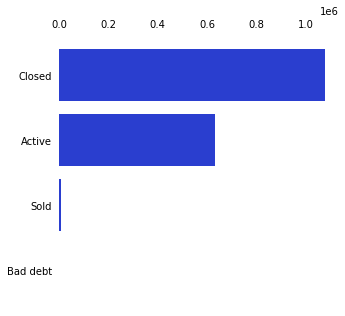

In [269]:
# Distribution
status_dis = bureau_data['CREDIT_ACTIVE'].value_counts().reset_index()
status_dis
status_dis.columns = ['status', 'amt']   #amount

fig, ax = plt.subplots(figsize = (5,5))
ax.barh(status_dis.status, status_dis.amt, height = 0.8, color = '#2A3ECF')

ax.spines[:].set_visible(False)   
    
ax.xaxis.tick_top()
ax.tick_params(left = False, top = False)
ax.invert_yaxis()



#### Comment:
- most of the applications in the bureau_data is closed, following by the status of being Active
- There are very few loans that are "Sold" or considered to be "Bad debt"

#### CREDIT_CURRENCY: Recoded currency of the Credit Bureau credit	recoded

In [270]:
bureau_data['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

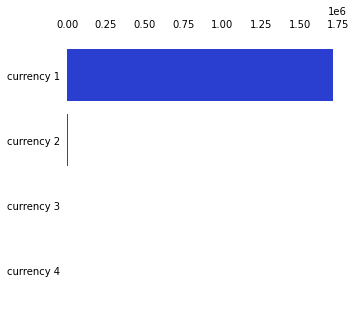

In [271]:

currency_dis = bureau_data['CREDIT_CURRENCY'].value_counts().reset_index()
currency_dis
currency_dis.columns = ['currency', 'amt']   #amount

fig, ax = plt.subplots(figsize = (5,5))
ax.barh(currency_dis.currency, currency_dis.amt, height = 0.8, color = '#2A3ECF')

ax.spines[:].set_visible(False)   
    
ax.xaxis.tick_top()
ax.tick_params(left = False, top = False)
ax.invert_yaxis()



#### Comment:
- Mostly the first kind of currency: currency 1

### DROP "CREDIT_CURRENCY"

In [272]:
 # 1715020 / (bureau_data.shape[0]) * 100 = 99.9..%
    
bureau_data = bureau_data.drop(columns = ['CREDIT_CURRENCY'], axis = 1)

#### 1.2 DAYS_CREDIT
DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit?

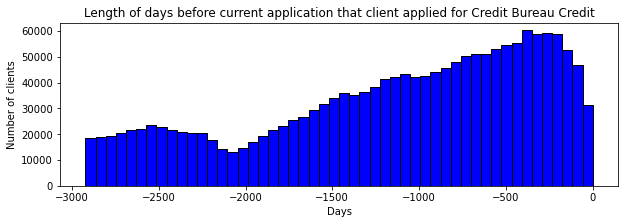

In [273]:
plt.figure(figsize = (10,3))
plt.hist(bureau_data['DAYS_CREDIT'].values, bins = 50, edgecolor = 'black',color = 'blue')
plt.title('Length of days before current application that client applied for Credit Bureau Credit')
plt.xlabel('Days')
plt.ylabel('Number of clients')
plt.show()

#### Comment:
- Most of clients applied for Bureau Credit is less than 500 days before the data of loan application


#### 1.3 CREDIT_DAY_OVERDUE
CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample

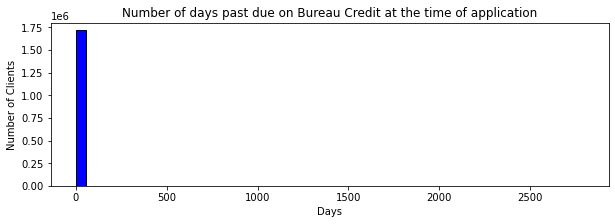

In [274]:
plt.figure(figsize =(10,3))
plt.hist(bureau_data['CREDIT_DAY_OVERDUE'].values, bins = 50, edgecolor = 'black', color = 'blue')
plt.title('Number of days past due on Bureau Credit at the time of application')
plt.xlabel('Days')
plt.ylabel('Number of Clients')
plt.show()

#### Comment:
- This shows that most of the clients have a low "days past due (close to 0)" on Credit Bureau at the time of their application since the histogram is very peaked near 0 

#### Let's look further at the respective percentile values as shown below

In [275]:
bureau_data[bureau_data['CREDIT_DAY_OVERDUE']>0].shape[0]

4217

there are total of 4217 (out of 1716428) datapoints where the CREDIT_DAY_OVERDUE value is greater than 0

In [276]:
# from scipy import stats
# stats.percentileofscore(bureau_data['CREDIT_DAY_OVERDUE'],13)

In [277]:
#pip install https://pypi.python.org/packages/source/P/PrettyTable/prettytable-0.7.2.tar.bz2

In [278]:

y = PrettyTable()
y.field_names = ['Percentile','Number of days past due on CB Credit']

for i in range(0,101,10):
    y.add_row([i, np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)])

print(y)

+------------+--------------------------------------+
| Percentile | Number of days past due on CB Credit |
+------------+--------------------------------------+
|     0      |                 0.0                  |
|     10     |                 0.0                  |
|     20     |                 0.0                  |
|     30     |                 0.0                  |
|     40     |                 0.0                  |
|     50     |                 0.0                  |
|     60     |                 0.0                  |
|     70     |                 0.0                  |
|     80     |                 0.0                  |
|     90     |                 0.0                  |
|    100     |                2792.0                |
+------------+--------------------------------------+


#### Comment:
- There is 0 day past due till the 90th percentile, while the 100th percentile is a value = 2792 (max =2792)

Now, let zoom in 99th - 100 percentile

In [279]:
y_1 = PrettyTable()
y_1.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in np.arange(99,100.1,0.1): 
    y_1.add_row(np.round([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)],2))
print(y_1)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|    99.0    |                0.0                |
|    99.1    |                0.0                |
|    99.2    |                0.0                |
|    99.3    |                0.0                |
|    99.4    |                0.0                |
|    99.5    |                0.0                |
|    99.6    |                0.0                |
|    99.7    |                0.0                |
|    99.8    |                13.0               |
|    99.9    |               52.57               |
|   100.0    |               2792.0              |
+------------+-----------------------------------+


#### Comment:
We can see from here that only the Top 0.3 percentile of values over here are non-zeroes.

### 1.4 CREDIT_TYPE

CREDIT_TYPE: Type of Credit Bureau credit (Car, cash,...)

In [280]:
bureau_data['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

In [281]:
# credit_type_counter = Counter()
# credit_type_counter
# for type in bureau_data['CREDIT_TYPE'].values:
#     credit_type_counter.update(type.split(','))

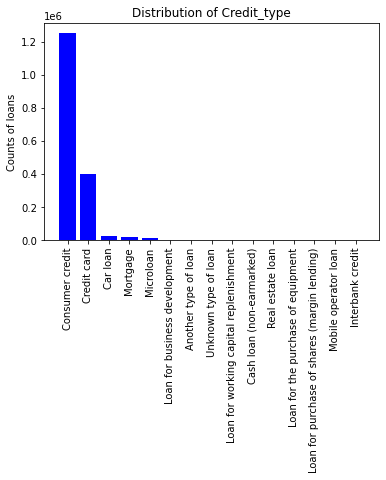

In [282]:
type_dict = dict(bureau_data['CREDIT_TYPE'].value_counts())
type_dict

sorted_type_dict = dict(sorted(type_dict.items(), key = lambda kv :kv[1],reverse = True))
ind_2 = np.arange(len(sorted_type_dict))
#ind_2 = array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
p1 = plt.bar(ind_2, list(sorted_type_dict.values()), color = 'blue')

plt.ylabel('Counts of loans')
plt.title('Distribution of Credit_type')
plt.xticks(ind_2, list(sorted_type_dict.keys()), rotation = 90)
plt.show()

#### Comment:
- Consumer Credit and Credit Cards are the mostly registered credit types in the Credit Bureau

--> we may assign the 13 remaining as one - Rare

In [283]:
# bureau_data['CREDIT_TYPE'] = bureau_data['CREDIT_TYPE'].replace(['Car loan',
#               'Mortgage',
#               'Microloan',
#               'Loan for business development', 
#               'Another type of loan',
#               'Unknown type of loan', 
#               'Loan for working capital replenishment',
#               "Loan for purchase of shares (margin lending)",                                                
#               'Cash loan (non-earmarked)', 
#               'Real estate loan',
#               "Loan for the purchase of equipment", 
#               "Interbank credit", 
#               "Mobile operator loan"], 'Rare')

### 1.5 CREDIT_ACTIVE vs DAYS_CREDIT

CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits
DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit

In [284]:
bureau_data['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

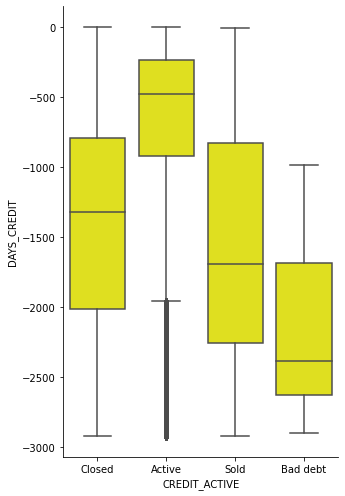

In [285]:
sns.catplot(x = 'CREDIT_ACTIVE', y = 'DAYS_CREDIT', data = bureau_data, color = 'yellow', kind = 'box', height = 7, aspect =.7)


#### Comment:
- When the Credit Status is Active, it means that the corresponding "DAYS_CREDIT" i.e number of days before application, the median value is approximately 500 days

# B - Feature Engineering on Bureau data and Bureau_Balance data

### BUILD HELPER COLUMNS

#### First, merge with application_train['TARGET']

In [330]:
train_data = reduce_memory_usage(pd.read_csv('application_train.csv'))
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
train_data.head()

Memmory usage of dataframe is 286.23 MB
Memory usage after optimization is 285.05 MB
Decreased by 0.4%
Number of data points :  307511
Number of features :  122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [331]:
bureau_merge_train = pd.merge(train_data[['SK_ID_CURR','TARGET']], bureau_data, how = 'left', on = ['SK_ID_CURR'])
bureau_merge_train.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


In [332]:
bureau_merge_train.shape

(1509345, 17)

In [293]:
(bureau_data['AMT_CREDIT_SUM'] == 0).sum()

66582

In [299]:
bureau_data[bureau_data['SK_ID_CURR']==215354]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN
225157,215354,5714458,Closed,-1872,0,-776.0,-1203.0,NaN,0,494550.0,0.00,0.00,0.0,Consumer credit,-696,NaN
225158,215354,5714459,Closed,-1734,0,-638.0,-1336.0,NaN,0,1084032.0,0.00,NaN,0.0,Car loan,-1336,NaN
225159,215354,5714460,Closed,-1333,0,-1089.0,-987.0,NaN,0,102150.0,NaN,NaN,0.0,Consumer credit,-984,NaN


In [333]:
groupby_SK_ID_CURR = bureau_merge_train.groupby(by=['SK_ID_CURR'])
groupby_SK_ID_CURR.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509334,456255,0,5126327.0,Closed,-1022.0,0.0,-959.0,-958.0,NaN,0.0,22995.0,0.0,0.0,0.0,Consumer credit,-890.0,0.0
1509335,456255,0,5126328.0,Closed,-970.0,0.0,-621.0,-712.0,NaN,0.0,27472.5,0.0,0.0,0.0,Consumer credit,-700.0,NaN
1509336,456255,0,5126329.0,Active,-573.0,0.0,523.0,NaN,NaN,0.0,553500.0,324171.0,0.0,0.0,Consumer credit,-19.0,0.0
1509337,456255,0,5126330.0,Closed,-1021.0,0.0,-959.0,-959.0,NaN,0.0,22995.0,0.0,NaN,0.0,Consumer credit,-953.0,3244.5


### number of loan types & number of past loans

In [337]:
df1 = bureau_merge_train[['SK_ID_CURR','DAYS_CREDIT','TARGET']].groupby(['SK_ID_CURR','TARGET'])['DAYS_CREDIT'].count().reset_index()
df1.columns = ['SK_ID_CURR', 'target','number_of_past_loans']
df2 = bureau_merge_train[['SK_ID_CURR', 'CREDIT_TYPE','TARGET']].groupby(['SK_ID_CURR','TARGET'])['CREDIT_TYPE'].nunique().reset_index()
df2.columns = ['SK_ID_CURR','target', 'number_of_loan_types']


df3 = df2.merge(df1, on=['SK_ID_CURR'], how='left')
df3.head()

,SK_ID_CURR,target_x,number_of_loan_types,target_y,number_of_past_loans
0,100002,1,2,1,8
1,100003,0,2,0,4
2,100004,0,1,0,2
3,100006,0,0,0,0
4,100007,0,1,0,1


In [338]:
df1.head() 

,SK_ID_CURR,target,number_of_past_loans
0,100002,1,8
1,100003,0,4
2,100004,0,2
3,100006,0,0
4,100007,0,1


[Text(0.5, 1.0, 'Defaultets')]

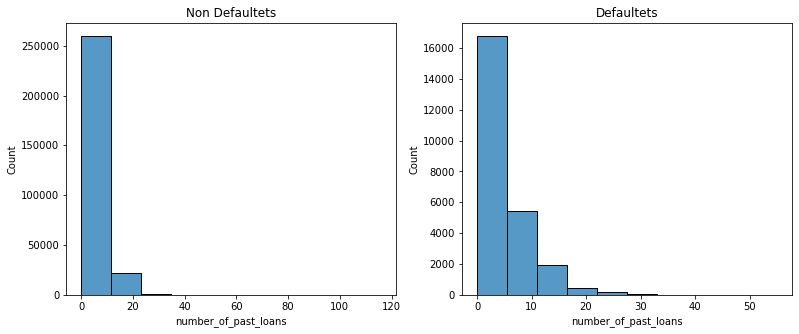

In [341]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
sns.histplot(df1[df1['target'] == 0]['number_of_past_loans'], ax = ax[0], bins = 10).set(title = 'Non Defaultets')
sns.histplot(df1[df1['target'] == 1]['number_of_past_loans'], ax = ax[1], bins = 10).set(title = 'Defaultets')



#### Comment:
- defaulters seem to be clearly to take more loans

In [347]:
df2.head()

,SK_ID_CURR,target,number_of_loan_types
0,100002,1,2
1,100003,0,2
2,100004,0,1
3,100006,0,0
4,100007,0,1


[Text(0.5, 1.0, 'Defaultets')]

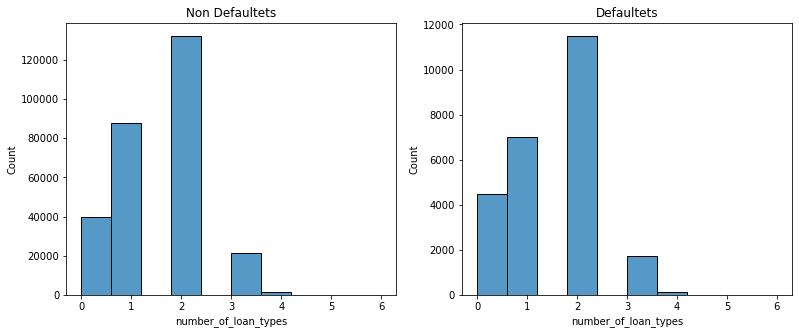

In [350]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
sns.histplot(df2[df2['target'] == 0]['number_of_loan_types'], ax = ax[0], bins = 10).set(title = 'Non Defaultets')
sns.histplot(df2[df2['target'] == 1]['number_of_loan_types'], ax = ax[1], bins = 10).set(title = 'Defaultets')




#### Comment: with alike distribution based on credit types, implying that, this factor did not affect TARGET

### Active loan per customer

In [354]:
def check(status):
    if status == 'Closed':
        y = 0
    else:
        y = 1
    return y

In [352]:
bureau_merge_train['CREDIT_ACTIVE'].value_counts()

Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64

In [360]:
bureau_merge_train['CREDIT_ACTIVE_BINARY'] = bureau_merge_train.apply(lambda x: check(x.CREDIT_ACTIVE), axis = 1)

perc_active_loans = bureau_merge_train.groupby(by = ['SK_ID_CURR', 'TARGET'])['CREDIT_ACTIVE_BINARY'].mean().reset_index()
perc_active_loans.columns = ['SK_ID_CURR', 'TARGET','PERC_ACTIVE_LOANS']
perc_active_loans.head()

,SK_ID_CURR,TARGET,PERC_ACTIVE_LOANS
0,100002,1,0.25
1,100003,0,0.25
2,100004,0,0.00
3,100006,0,1.00
4,100007,0,0.00


[Text(0.5, 1.0, 'Defaultets')]

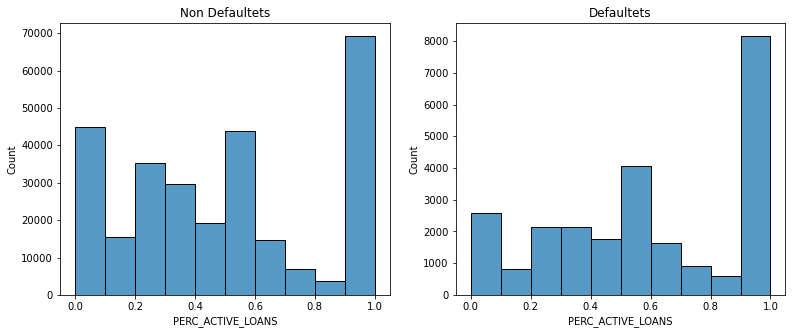

In [362]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
sns.histplot(perc_active_loans[perc_active_loans['TARGET'] == 0]['PERC_ACTIVE_LOANS'], ax = ax[0], bins = 10).set(title = 'Non Defaultets')
sns.histplot(perc_active_loans[perc_active_loans['TARGET'] == 1]['PERC_ACTIVE_LOANS'], ax = ax[1], bins = 10).set(title = 'Defaultets')



#### Comment:
- We see the different points at 0.2, 0.5 between target of 0 and 1


<Figure size 720x576 with 0 Axes>

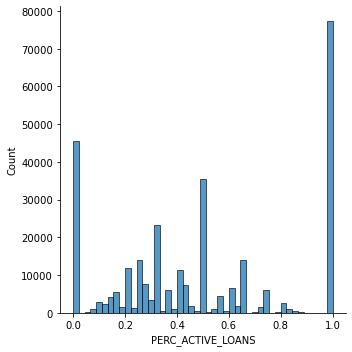

In [381]:
plt.figure(figsize=(10,8))
sns.displot(perc_active_loans.PERC_ACTIVE_LOANS)
plt.show()

#### The percentage of loans per customer (enddate of the loans are < 0 or > 0)
- DAY_CREDIT_ENDDATE > 0: The due is not met yet (future) --> good
- DAY_CREDIT_ENDDATE < 0: overdue --> bad

In [375]:
def check1(x):
    if x < 0:
        y = 0
    else: y = 1
    return y

In [376]:
bureau_merge_train['BUREAU_CREDIT_ENDDATE_BINARY'] = bureau_merge_train['DAYS_CREDIT_ENDDATE']
bureau_merge_train['BUREAU_CREDIT_ENDDATE_BINARY'] = bureau_merge_train.apply(lambda x: check1(x.DAYS_CREDIT_ENDDATE),axis = 1)
df4 = bureau_merge_train.groupby(by = ['SK_ID_CURR', 'TARGET'])['BUREAU_CREDIT_ENDDATE_BINARY'].mean().reset_index()
df4.columns = ['SK_ID_CURR', 'TARGET','BUREAU_CREDIT_ENDDATE_PERCENTAGE']
df4.head()

,SK_ID_CURR,TARGET,BUREAU_CREDIT_ENDDATE_PERCENTAGE
0,100002,1,0.625
1,100003,0,0.250
2,100004,0,0.000
3,100006,0,1.000
4,100007,0,0.000


[Text(0.5, 1.0, 'Defaultets')]

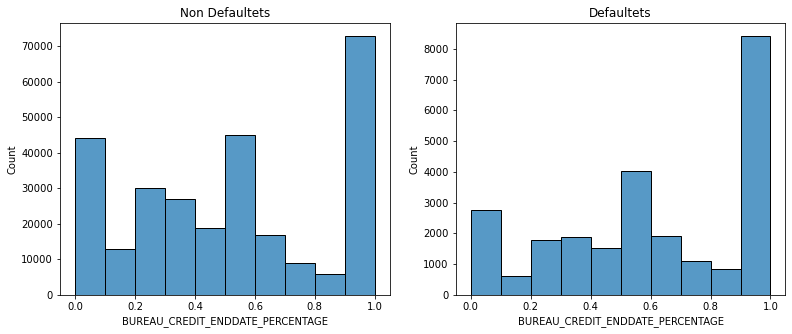

In [377]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
sns.histplot(df4[df4['TARGET'] == 0]['BUREAU_CREDIT_ENDDATE_PERCENTAGE'], ax = ax[0], bins = 10).set(title = 'Non Defaultets')
sns.histplot(df4[df4['TARGET'] == 1]['BUREAU_CREDIT_ENDDATE_PERCENTAGE'], ax = ax[1], bins = 10).set(title = 'Defaultets')




In [378]:
df4[df4['SK_ID_CURR'] == 100002]

,SK_ID_CURR,TARGET,BUREAU_CREDIT_ENDDATE_PERCENTAGE
0,100002,1,0.625


In [379]:
df4[df4['SK_ID_CURR'] == 100003]

,SK_ID_CURR,TARGET,BUREAU_CREDIT_ENDDATE_PERCENTAGE
1,100003,0,0.25


<Figure size 720x576 with 0 Axes>

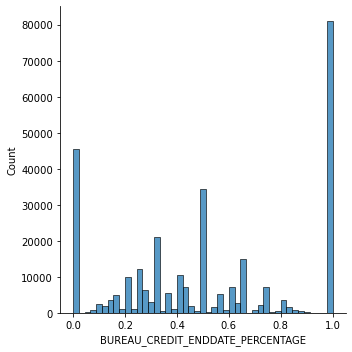

In [383]:
plt.figure(figsize=(10,8))
sns.displot(df4.BUREAU_CREDIT_ENDDATE_PERCENTAGE)
plt.show()

#### Comment:
- distribution of percentage is mostly at 0, 0.5, 1

### Ratio of Total Debt to Total Credit of each customer

In [403]:
debt_to_credit2 = bureau_merge_train[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

debt_to_credit1 = bureau_merge_train[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})

bureau_merge_train = bureau_merge_train.merge(debt_to_credit1, on = ['SK_ID_CURR'], how = 'left')
bureau_merge_train = bureau_merge_train.merge(debt_to_credit2, on = ['SK_ID_CURR'], how = 'left')
del debt_to_credit1, debt_to_credit2


bureau_merge_train['DEBT_TO_CREDIT'] = bureau_merge_train['TOTAL_CUSTOMER_DEBT']/bureau_merge_train['TOTAL_CUSTOMER_CREDIT']

del bureau_merge_train['TOTAL_CUSTOMER_DEBT'], bureau_merge_train['TOTAL_CUSTOMER_CREDIT']

debt_to_credit = bureau_merge_train.groupby(by = ['SK_ID_CURR','TARGET'])['DEBT_TO_CREDIT'].mean().reset_index().rename(index=str)
debt_to_credit

,SK_ID_CURR,TARGET,DEBT_TO_CREDIT
0,100002,1,0.284122
1,100003,0,0.000000
2,100004,0,0.000000
3,100006,0,NaN
4,100007,0,0.000000
...,...,...,...
307506,456251,0,NaN
307507,456252,0,NaN
307508,456253,0,0.453493
307509,456254,1,0.000000


[Text(0.5, 1.0, 'Defaultets')]

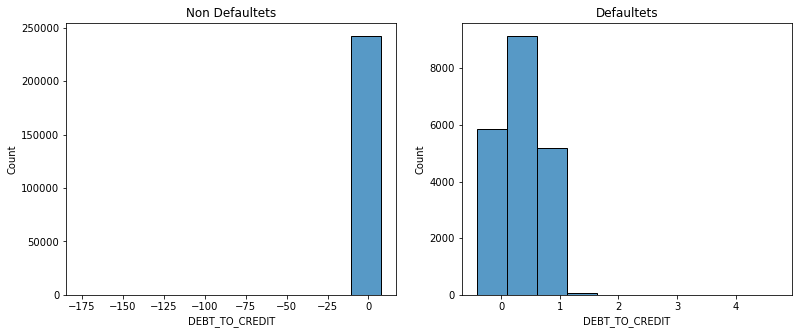

In [401]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
sns.histplot(debt_to_credit[debt_to_credit['TARGET'] == 0]['DEBT_TO_CREDIT'], ax = ax[0], bins = 10).set(title = 'Non Defaultets')
sns.histplot(debt_to_credit[debt_to_credit['TARGET'] == 1]['DEBT_TO_CREDIT'], ax = ax[1], bins = 10).set(title = 'Defaultets')



#### Comment:
- we see that the ratio of debt to credit of non defaulter is mostly 0, while defaulters share other distribution for bigger value (it means they still have debts)

### Number of Loans Prolonged (gia han)

In [406]:
loan_prolong = bureau_merge_train[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename( index = str, columns = { 'CNT_CREDIT_PROLONG': 'AVG_CREDITDAYS_PROLONGED'})
loan_prolong

,SK_ID_CURR,AVG_CREDITDAYS_PROLONGED
0,100002,0.000000
1,100003,0.000000
2,100004,0.000000
3,100006,NaN
4,100007,0.000000
...,...,...
307506,456251,NaN
307507,456252,NaN
307508,456253,0.000000
307509,456254,0.000000


<Figure size 576x432 with 0 Axes>

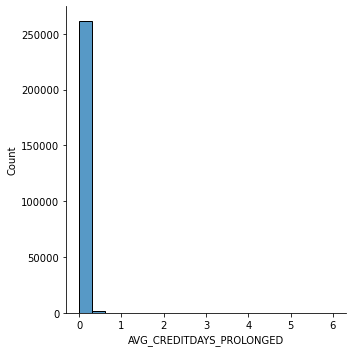

In [407]:
plt.figure(figsize=(8,6))
sns.displot(loan_prolong.AVG_CREDITDAYS_PROLONGED)
plt.show()

## 2. Bureau_Blance

In [286]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [287]:
bureau_balance.shape

(27299925, 3)

In [288]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

### 2.1 Status
Status of Credit Bureau loan during the month (active, closed, DPD0-30,Ö [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,Ö 5 means DPD 120+ or sold or written off ] )	

In [289]:
bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

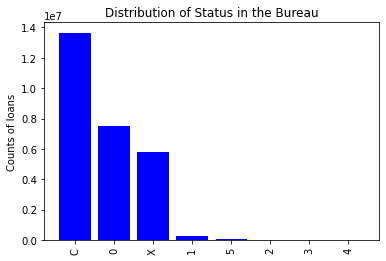

In [290]:
status_dict = dict(bureau_balance['STATUS'].value_counts())
status_dict

sorted_status_dict = dict(sorted(status_dict.items(), key = lambda kv :kv[1],reverse = True))
ind_2 = np.arange(len(sorted_status_dict))

p1 = plt.bar(ind_2, list(sorted_status_dict.values()), color = 'blue')

plt.ylabel('Counts of loans')
plt.title('Distribution of Status in the Bureau')
plt.xticks(ind_2, list(sorted_status_dict.keys()), rotation = 90)
plt.show()

#### Comment:
- Most of the loans are closed in the Credit Bureau, which is followed by clients with 0 DPD and then by applicants whose status is unknown
- We can conclude that there are very few annuity defaulters in the data